In [22]:
"""
Data Preprocessing Stage
"""
# import packages
import os
from glob import glob
import pandas as pd

# dataset path
dataset_path = 'dataset/raw/IMS/2nd_test'

# collect all file paths in a list (sorted)
data_files = sorted(glob(os.path.join(dataset_path, '*')))

# check if data_files is empty or not
if not data_files:
    print("No files found. Check dataset path")
else:
    print(f"Processing {len(data_files)} files")
    
# store the data in each file in a temporary dataframe
df_list = []
for file in data_files[:10]:
    temp_df = pd.read_csv(file, sep='\t', header=None, nrows=984, usecols=[0,1,2,3], names=['Ch1', 'Ch2', 'Ch3', 'Ch4'])
    print(len(temp_df))
    df_list.append(temp_df)
    
# combine into a single dataframe
combined_df = pd.concat(df_list, ignore_index=True)

# verify combined_df is not empty
if combined_df.empty:
    print("The combined dataframe is empty")
else:
    print("Combined dataframe records:", combined_df.head(20), sep='\n')

# save combined_df as a csv file for later use
output_path = os.path.join('dataset/cleansed/IMS/2nd_test', 'combined_data.csv')
combined_df.to_csv(output_path, index=False)
print(f"Combined data saved to {output_path}")
print("Total count of records in combined_df: ", len(combined_df))

Processing 984 files
984
984
984
984
984
984
984
984
984
984
Combined dataframe records:
      Ch1    Ch2    Ch3    Ch4
0  -0.049 -0.071 -0.132 -0.010
1  -0.042 -0.073 -0.007 -0.105
2   0.015  0.000  0.007  0.000
3  -0.051  0.020 -0.002  0.100
4  -0.107  0.010  0.127  0.054
5  -0.078 -0.212  0.042 -0.044
6  -0.020 -0.010 -0.144 -0.007
7  -0.046  0.112  0.034  0.034
8  -0.063 -0.154  0.071  0.076
9   0.068  0.044 -0.029  0.054
10  0.095  0.022 -0.090 -0.037
11 -0.007  0.007 -0.024 -0.095
12 -0.046  0.000 -0.122 -0.059
13  0.044 -0.002 -0.068  0.027
14  0.137  0.007  0.054  0.073
15  0.098 -0.032  0.088 -0.029
16  0.081 -0.081 -0.090 -0.105
17 -0.073  0.042 -0.137 -0.083
18 -0.037  0.037  0.020 -0.015
19  0.012 -0.020  0.176 -0.005
Combined data saved to dataset/cleansed/IMS/2nd_test/combined_data.csv
Total count of records in combined_df:  9840


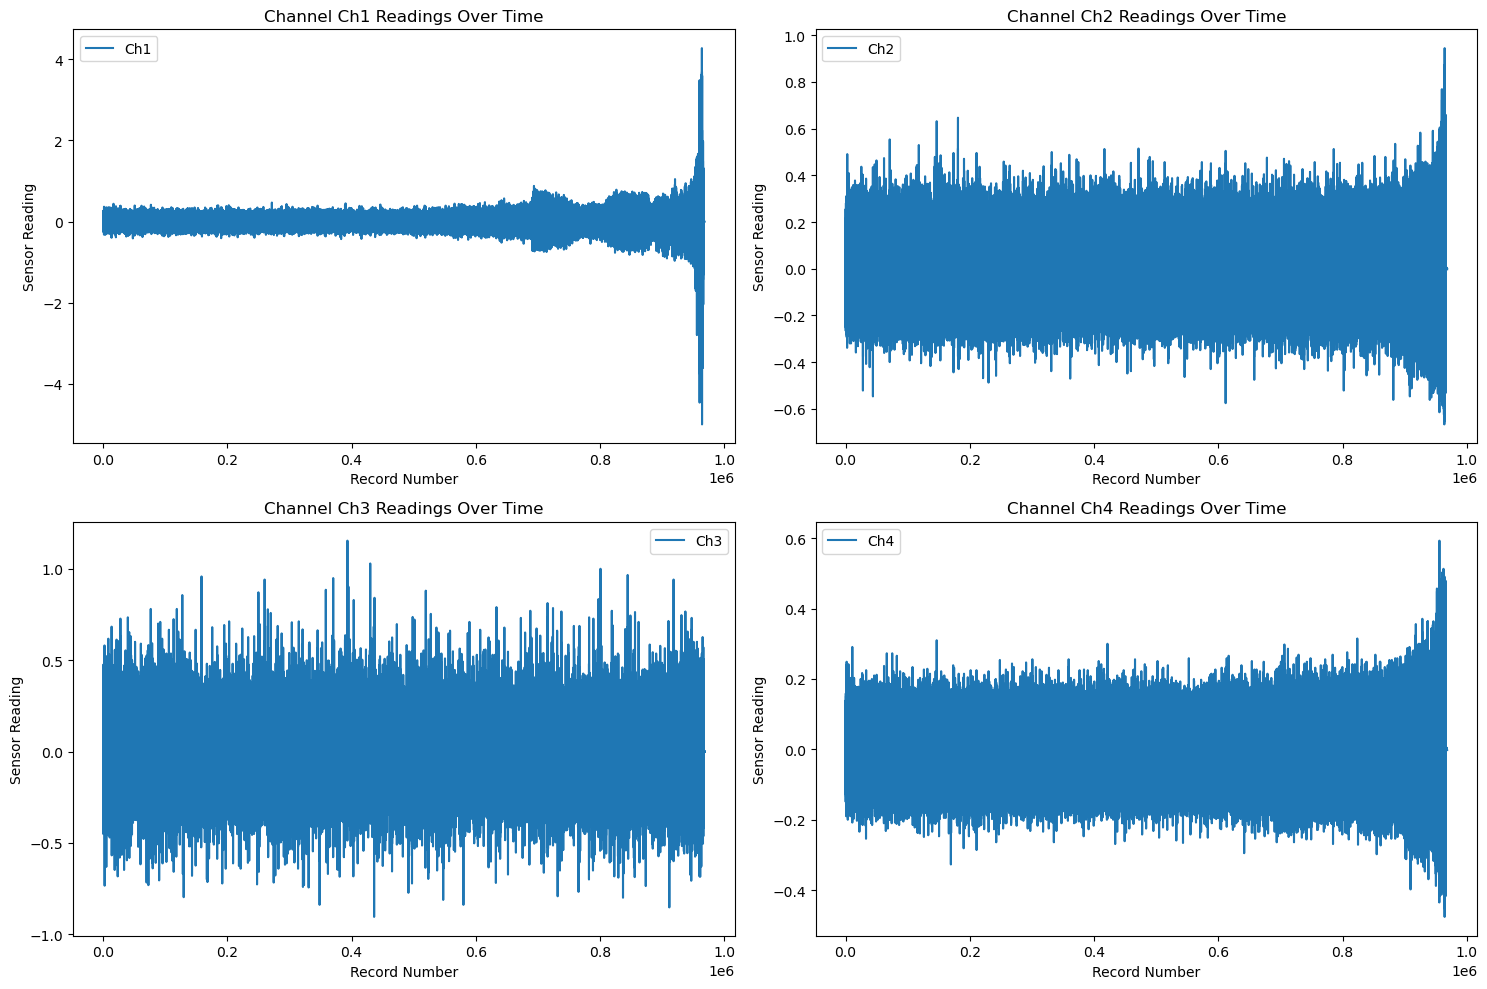

In [10]:
"""
Exploratory Data Analysis
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i, column in enumerate(combined_df.columns):
    plt.subplot(2, 2, i+1)
    plt.plot(combined_df[column], label=column)
    plt.xlabel("Record Number")
    plt.ylabel("Sensor Reading")
    plt.title(f"Channel {column} Readings Over Time")
    plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Statistical summary
print(combined_df.describe())

                 Ch1            Ch2            Ch3            Ch4
count  968256.000000  968256.000000  968256.000000  968256.000000
mean       -0.001754      -0.001921      -0.001755      -0.001884
std         0.120562       0.099753       0.105300       0.061358
min        -5.000000      -0.667000      -0.906000      -0.476000
25%        -0.061000      -0.068000      -0.068000      -0.042000
50%        -0.002000      -0.002000      -0.002000      -0.002000
75%         0.059000       0.063000       0.063000       0.037000
max         4.275000       0.945000       1.155000       0.593000


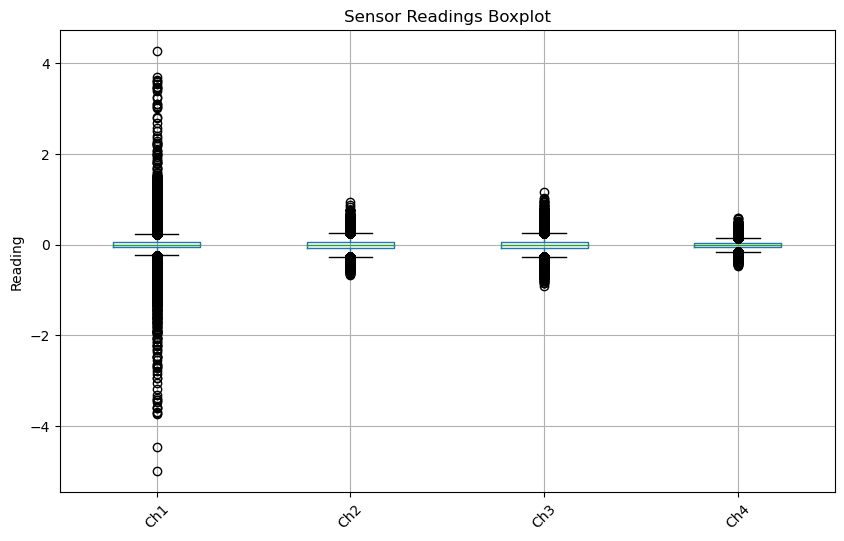

In [12]:
# checking for outliers
plt.figure(figsize=(10, 6))
combined_df.boxplot()
plt.title("Sensor Readings Boxplot")
plt.ylabel("Reading")
plt.xticks(rotation=45)
plt.show()

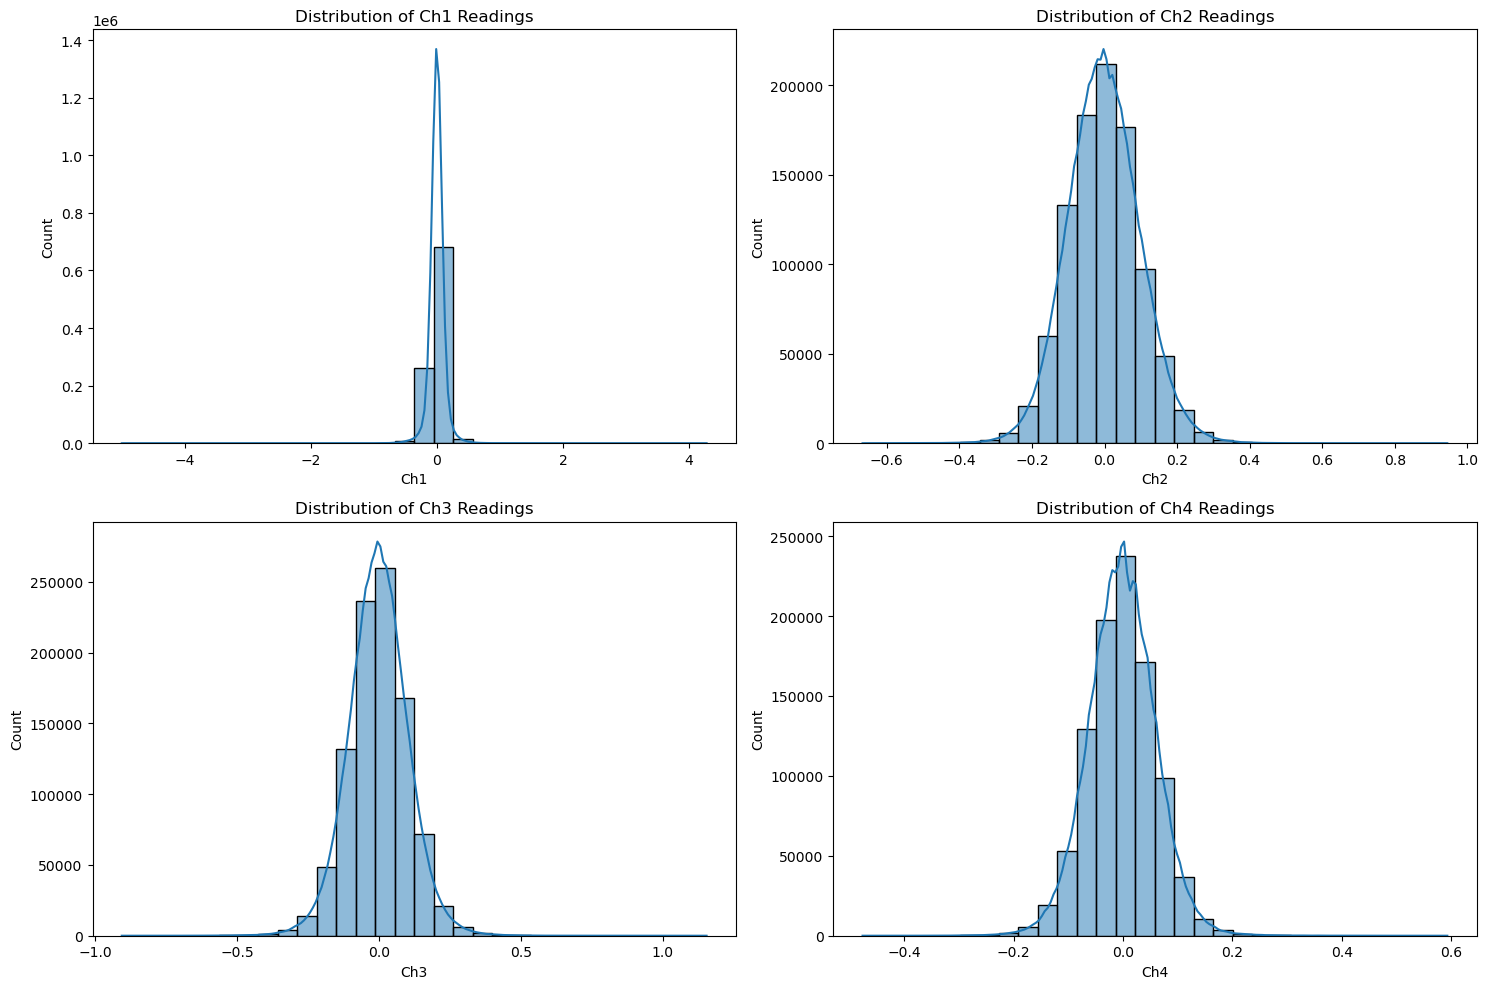

In [13]:
# distribution of sensor readings
plt.figure(figsize=(15, 10))

for i, column in enumerate(combined_df.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(combined_df[column], bins=30, kde=True)
    plt.title(f"Distribution of {column} Readings")

plt.tight_layout()
plt.show()

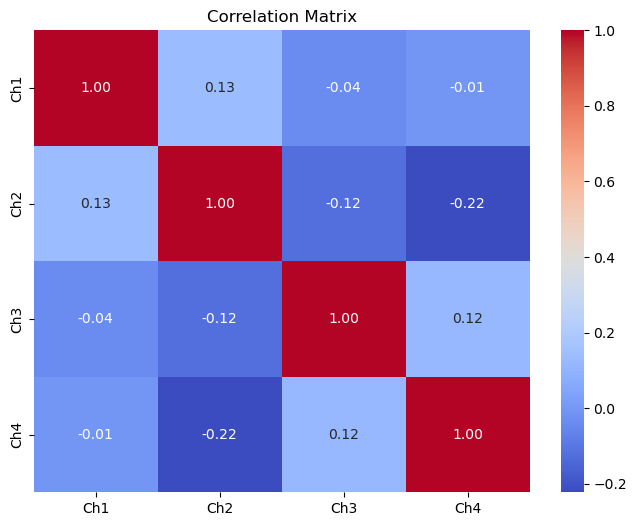

In [14]:
# Correlation Matrix
import seaborn as sns

corr = combined_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [15]:
"""
Generate Output Labels
"""
import numpy as np

# Example parameters (adjust based on your dataset and analysis)
# failure_point = len(combined_df)  # Assuming failure occurs at the last recorded point
# pre_failure_window = 480  # last 480 records as faulty as records are taken every 10 minutes

# Initialize labels as 0 (normal)
# labels = np.zeros(len(combined_df))

# Label the last 'pre_failure_window' records as 1 (faulty)
# labels[-pre_failure_window:] = 1

# Now, 'labels' can be used as your target variable 'y'


# Labeling the last 1% of records as faulty
pre_failure_window = int(0.05 * len(combined_df))  # 5% of total records

labels = np.zeros(len(combined_df))
labels[-pre_failure_window:] = 1  # Adjusting the pre-failure window

In [16]:
"""
Feature Engineering
"""
# no additional feature engineering required for the Sequential model
# data seems to be in a suitable format

# lets reshape data for CNN
features_cnn = combined_df.values.reshape(-1, 4, 1)

In [17]:
"""
Splitting data for Training and Testing
"""
from sklearn.model_selection import train_test_split

X_train_seq, X_test_seq, y_train, y_test = train_test_split(combined_df, labels, test_size=0.2, random_state=42)
X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(features_cnn, labels, test_size=0.2, random_state=42)

In [18]:
"""
Model - Sequential
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

seq_model = Sequential([
    Flatten(input_shape=(4,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

seq_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/ketanpatil/anaconda3/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
"""
Model - CNN
"""
from tensorflow.keras.layers import Conv1D, MaxPooling1D

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(4,1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/ketanpatil/anaconda3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
"""
Training the models
"""
seq_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_split=0.1)
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 7s 284us/step - accuracy: 0.9517 - loss: 0.1676 - val_accuracy: 0.9564 - val_loss: 0.1493
Epoch 2/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 286us/step - accuracy: 0.9543 - loss: 0.1530 - val_accuracy: 0.9564 - val_loss: 0.1492
Epoch 3/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 289us/step - accuracy: 0.9549 - loss: 0.1509 - val_accuracy: 0.9553 - val_loss: 0.1500
Epoch 4/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 283us/step - accuracy: 0.9549 - loss: 0.1506 - val_accuracy: 0.9566 - val_loss: 0.1477
Epoch 5/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 285us/step - accuracy: 0.9548 - loss: 0.1506 - val_accuracy: 0.9567 - val_loss: 0.1475
Epoch 6/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 284us/step - accuracy: 0.9550 - loss: 0.1498 - val_accuracy: 0.9567 - val_loss: 0.1476
Epoch 7/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 292us/step - accuracy: 0.9551 - loss: 0.1490 - val_accuracy: 0.9565 - val_loss: 0.1473
Epoch 8/10
21786/21786 ━━━━━━━━━━━━━━━━━━━━ 6s 287us/step - ac

In [21]:
"""
Evaluation
"""
from sklearn.metrics import classification_report

# Sequential model evaluation
y_pred_seq = (seq_model.predict(X_test_seq) > 0.5).astype(int)
print("Sequential Model Performance")
print(classification_report(y_test, y_pred_seq))

# CNN model evaluation
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
print("CNN Model Performance")
print(classification_report(y_test, y_pred_cnn))

6052/6052 ━━━━━━━━━━━━━━━━━━━━ 1s 188us/step
Sequential Model Performance
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    184007
         1.0       0.68      0.21      0.32      9645

    accuracy                           0.96    193652
   macro avg       0.82      0.60      0.65    193652
weighted avg       0.95      0.96      0.94    193652

6052/6052 ━━━━━━━━━━━━━━━━━━━━ 1s 209us/step
CNN Model Performance
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98    184007
         1.0       0.69      0.19      0.30      9645

    accuracy                           0.96    193652
   macro avg       0.82      0.59      0.64    193652
weighted avg       0.95      0.96      0.94    193652

